# Figure 5
Data is assumed to be in the folder "../../data/sequencing_runs/" if that is not true change below

## setup

In [3]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from qmap_paper.titration import normalize_data, normalized_hill_equation, compute_mg_1_2
from qmap_paper.plotting import plot_mg_titration_fit, publication_style_ax

# general figure tweaks
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 20
plt.rcParams["figure.facecolor"] = "white"

In [4]:
# assume this is where the data is change if not true
DATA_PATH = "../../data/"

In [5]:
df_wt_mg = pd.read_json(f"{DATA_PATH}/sequencing_runs/processed/wt_mg_titra.json")
df_wt_buff = pd.read_json(f"{DATA_PATH}/sequencing_runs/processed/wt_buffer_titra.json")
df_mttr6_muts = pd.read_json(f"{DATA_PATH}/sequencing_runs/processed/mttr6_muts_titra.json")
df_mttr6_full = pd.read_json(f"{DATA_PATH}/sequencing_runs/processed/mttr6_data_full.json")
df_dg = pd.read_csv(f"{DATA_PATH}/mg_1_2_fits/mtt6_data_mg_1_2_final.csv")


In [6]:
df_mttr6_full = df_mttr6_full[df_mttr6_full["mg_conc"] != 5.0]

### extra functions

In [7]:
def r2(x, y):
    """
    Calculates the coefficient of determination (R-squared) between two arrays.

    Args:
        x (array-like): The first array.
        y (array-like): The second array.

    Returns:
        float: The coefficient of determination (R-squared) between x and y.

    Raises:
        None

    Examples:
        >>> x = [1, 2, 3, 4, 5]
        >>> y = [2, 4, 6, 8, 10]
        >>> r2(x, y)
        1.0
    """
    return round(stats.pearsonr(x, y)[0] ** 2, 3)

def stringify_parameters(p):
    """
    Converts the given parameters into a string representation.

    Args:
        p (list): A list of parameters [Kd, n, Bmax].

    Returns:
        str: A string representation of the parameters in the format "Kd: {Kd}, n: {n}, Bmax: {Bmax}".
    """
    return f"Kd: {p[0]:.3f}, n: {p[1]:.3f}, Bmax: {p[2]:.3f}"

## plots

In [8]:
df_wt = df_wt_mg[df_wt_mg["run_name"] == "2022_07_27_minittr_50mM_NaC_Mg_titra_seq"]
df_upper = df_mttr6_full[df_mttr6_full["name"] == "CCUAAA_CAUGG"]
df_lower = df_mttr6_full[df_mttr6_full["name"] == "CCCUAAC_CACGG"]

fit parameters for wild-type Kd: 0.229, n: 1.434, Bmax: 0.938 
fit parameters for CCUAAA_CAUGG Kd: 0.212, n: 1.269, Bmax: 0.945 
fit parameters for CCCUAAC_CACGG Kd: 3.414, n: 1.296, Bmax: 0.767 


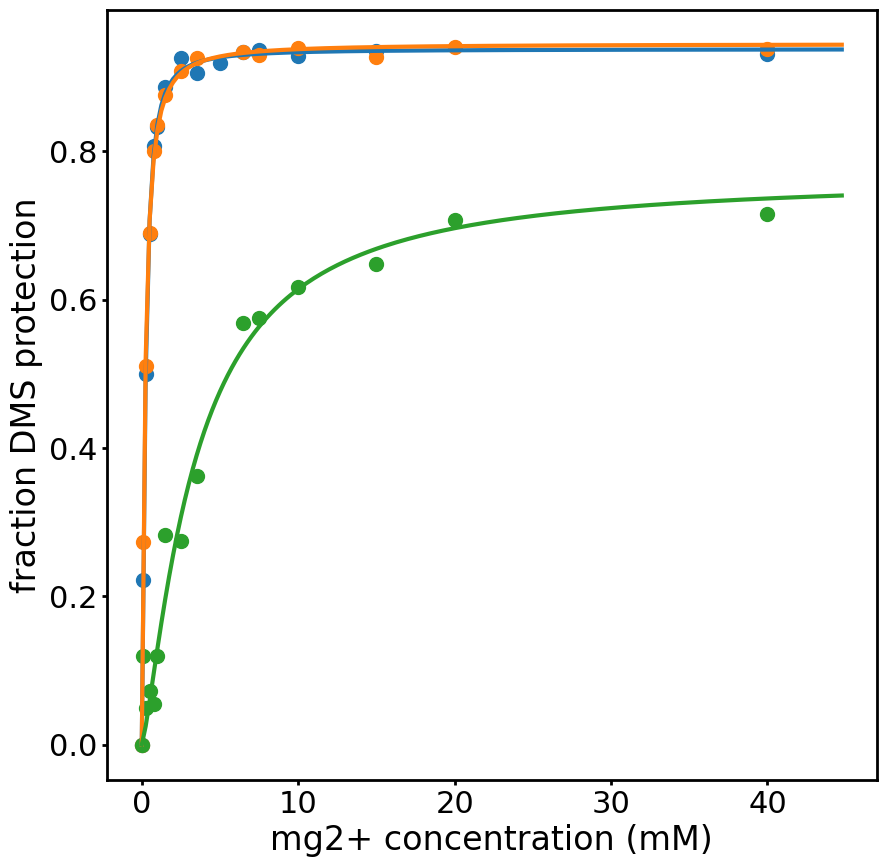

In [9]:
fig, ax = plt.subplots()
pfit, perr = compute_mg_1_2(df_wt["mg_conc"], df_wt["gaaa_avg"])
plot_mg_titration_fit(df_wt["mg_conc"], df_wt["gaaa_avg"], pfit[0], pfit[1], pfit[2], ax=ax)
print(f"fit parameters for wild-type {stringify_parameters(pfit)} ")
pfit, perr = compute_mg_1_2(df_upper["mg_conc"], df_upper["gaaa_avg"])
plot_mg_titration_fit(df_upper["mg_conc"], df_upper["gaaa_avg"], pfit[0], pfit[1], pfit[2], ax=ax)
print(f"fit parameters for CCUAAA_CAUGG {stringify_parameters(pfit)} ")
pfit, perr = compute_mg_1_2(df_lower["mg_conc"], df_lower["gaaa_avg"])
plot_mg_titration_fit(df_lower["mg_conc"], df_lower["gaaa_avg"], pfit[0], pfit[1], pfit[2], ax=ax)
print(f"fit parameters for CCCUAAC_CACGG {stringify_parameters(pfit)} ")
publication_style_ax(ax)
ax.set_ylabel("fraction DMS protection")
ax.set_xlabel("mg2+ concentration (mM)")
ax.set_box_aspect(1)

In [10]:
df_dg.columns

Index(['name', 'mg_1_2', 'sequence', 'structure', 'rna-map-dg',
       'rna-map-dg-error', 'mg_1_2_err', 'discarded'],
      dtype='object')

In [11]:
# check supplemental table 4 for reasons
exclude = [
    "UCUAAA_CAUGA",
    "CCUACA_UACGG",
    "CUUAAC_UAUGG",
    "CCUCAC_CACGG",
    "GCUCAA_CAUGC",
    "GCUGAA_CAUGC",
    "CCUCAA_CAUGG",
    "CCUGAA_CAUGG",
    "CCUAAAG_UAAGG",
    "CCUAAC_UAGGG",
    "CCUCAC_UAUGG",
]

df_sub = df_dg[~df_dg["name"].isin(exclude)].copy()
df_sub['mg_1_2'] = df_sub['mg_1_2'].astype(float)
df_sub['ln_mg_1_2'] = np.log(df_sub['mg_1_2'])


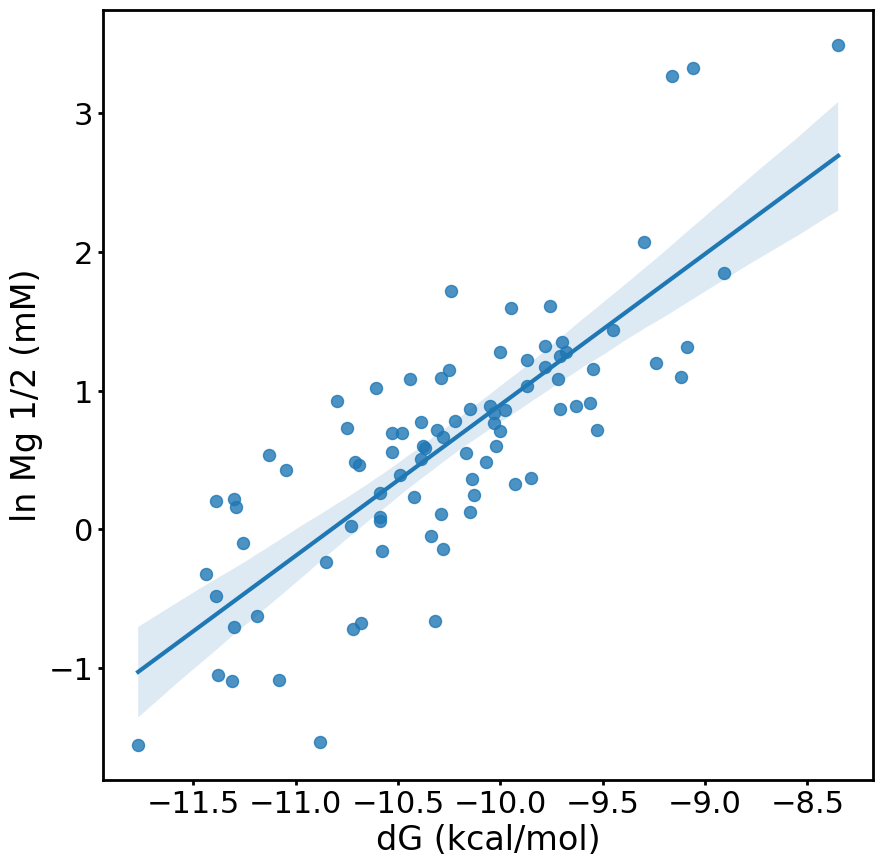

In [12]:
fig, ax = plt.subplots()
sns.regplot(x="rna-map-dg", y="ln_mg_1_2", data=df_sub, ax=ax, scatter_kws={"s": 75}, line_kws={"lw" : 3})
ax.set_box_aspect(1)
ax.set_xlabel("dG (kcal/mol)")
ax.set_ylabel("ln Mg 1/2 (mM)")
publication_style_ax(ax)


In [13]:
r2(df_sub["rna-map-dg"], df_sub["ln_mg_1_2"])

0.634

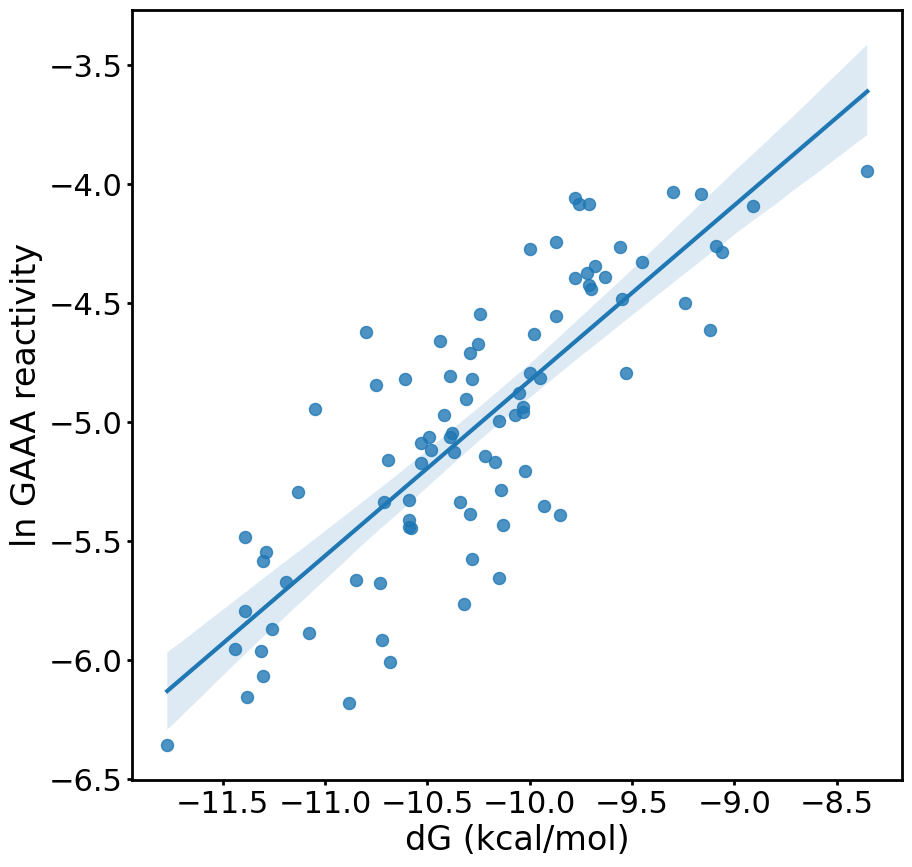

In [14]:
df_sub_mg = df_mttr6_full[df_mttr6_full["mg_conc"] == 7.5]
fig, ax = plt.subplots()
df_dg = df_dg[~df_dg["name"].isin(exclude)]
df_sub_mg = df_sub_mg.merge(df_dg, on="name")
df_sub_mg["ln_gaaa_avg"] = np.log(df_sub_mg["gaaa_avg"])
sns.regplot(x="rna-map-dg", y="ln_gaaa_avg", data=df_sub_mg, ax=ax, scatter_kws={"s": 75}, line_kws={"lw" : 3})
ax.set_box_aspect(1)
ax.set_xlabel("dG (kcal/mol)")
ax.set_ylabel("ln GAAA reactivity")
publication_style_ax(ax)


In [15]:
r2(df_sub_mg["dg"], df_sub_mg["ln_gaaa_avg"])

0.669

In [16]:
x_mean = df_sub_mg["dg"].mean()
y_mean = df_sub_mg["ln_gaaa_avg"].mean()
b = y_mean - x_mean

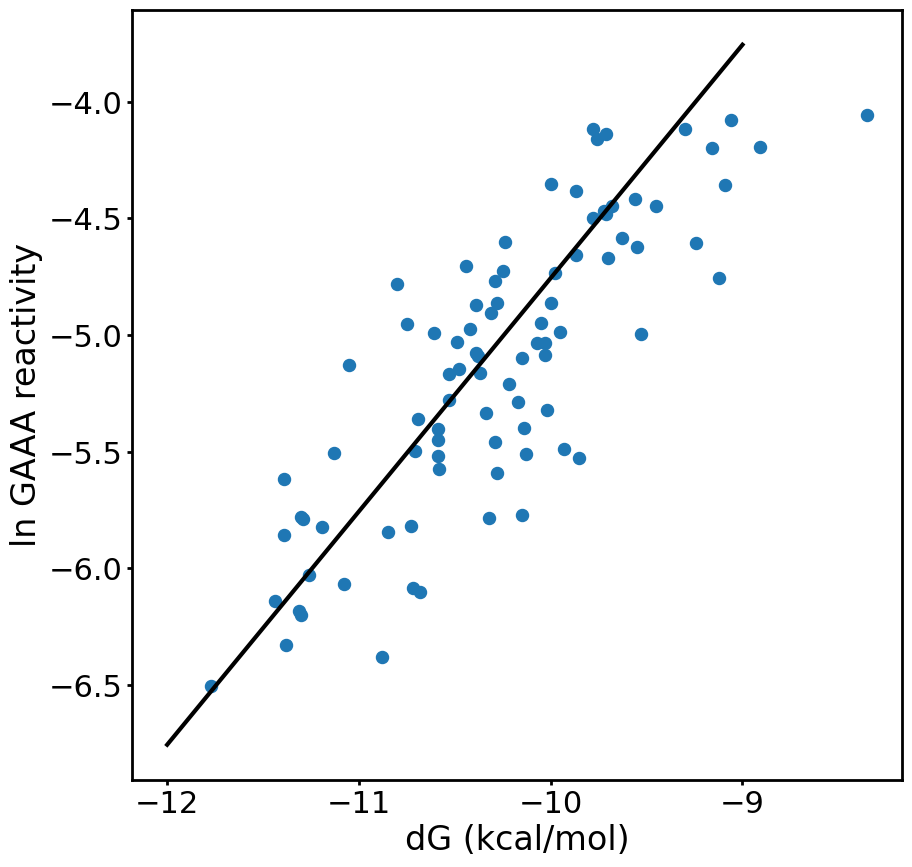

In [17]:
df_sub_mg = df_mttr6_full[df_mttr6_full["mg_conc"] == 10.0]
fig, ax = plt.subplots()
df_sub_mg = df_sub_mg[~df_sub_mg["name"].isin(exclude)]
df_sub_mg.merge(df_dg, on="name")
df_sub_mg["ln_gaaa_avg"] = np.log(df_sub_mg["gaaa_avg"])
plt.scatter(df_sub_mg["dg"], df_sub_mg["ln_gaaa_avg"], s=75)
plt.plot(range(-12, -8), range(-12, -8) + b, color='black', lw=3)
ax.set_box_aspect(1)
ax.set_xlabel("dG (kcal/mol)")
ax.set_ylabel("ln GAAA reactivity")
publication_style_ax(ax)


In [18]:
y_best_fit = df_sub_mg["dg"] + b
y = df_sub_mg["ln_gaaa_avg"]
# Calculate SS_res and SS_tot
SS_res = np.sum((y - y_best_fit)**2)
SS_tot = np.sum((y - np.mean(y))**2)

# Calculate R^2
R_squared = 1 - (SS_res / SS_tot)
print(R_squared)

0.5839296329504319
